# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import xy_variables, df_to_dummy, stratified_split, up_sampling
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 10

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'mlp_basic(protein_augmented)'

x_cts   = variables.x_cts_original
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

11 x_cts: ['ASA', 'Phi', 'Psi', 'Theta(i-1=>i+1)', 'Tau(i-2=>i+2)', 'HSE_alpha_up', 'HSE_alpha_down', 'P(C)', 'P(H)', 'P(E)', 'flexibility']
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (8910, 16)
dummy y shape: (8910, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: 'SEQ_S',
 12: 'SEQ_T',
 13: 'SS_C',
 14: 'SS_E',
 15: 'SS_H'}

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_size, save_path=save_path)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.01669449081803005 1.0099778270509978
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_1of10.h5

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: 0.0 1.0287162162162165
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_2of10.h5

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.00027793218454695475 1.0287162162162165
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_3of10.h5

4th iteration
train/test dataset: <class 

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,90,4.507,0.647385,0.643587,0.633396,60.10,3.19,62.16,6.08
1,5,100,63,2.852,0.643845,0.639590,0.634054,60.33,2.55,48.65,4.85
2,5,100,115,4.958,0.655390,0.647809,0.643337,59.82,3.68,72.97,7.01
3,5,100,65,3.910,0.645885,0.641722,0.623183,62.07,3.22,59.46,6.11
4,5,100,50,2.800,0.647962,0.647170,0.630194,63.97,3.68,64.86,6.96
5,5,100,56,1.506,0.647550,0.644531,0.628985,61.67,3.32,62.16,6.31
6,5,100,28,0.975,0.655110,0.649211,0.628589,63.69,3.65,64.86,6.91
7,5,100,78,1.762,0.638424,0.636482,0.622163,63.64,2.64,45.95,4.99
8,5,100,117,2.427,0.652641,0.656866,0.638967,62.07,4.29,81.08,8.15
9,5,100,116,2.495,0.640142,0.634279,0.628012,63.30,3.04,54.05,5.76



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.01669449081803005 1.0099778270509978
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_1of10.h5


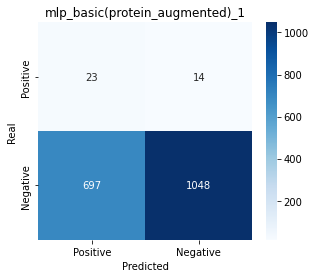

accuracy  : 60.099999999999994
precision : [98.68  3.19]
recall    : [60.06 62.16]
f1_score  : [74.67  6.08]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: 0.0 1.0287162162162165
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_2of10.h5


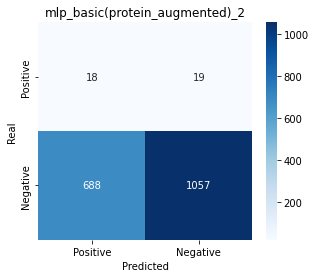

accuracy  : 60.33
precision : [98.23  2.55]
recall    : [60.57 48.65]
f1_score  : [74.94  4.85]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.00027793218454695475 1.0287162162162165
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_3of10.h5


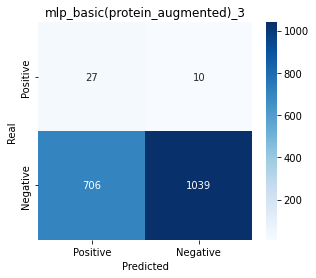

accuracy  : 59.81999999999999
precision : [99.05  3.68]
recall    : [59.54 72.97]
f1_score  : [74.37  7.01]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.03663003663003664 1.0136986301369864
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_4of10.h5


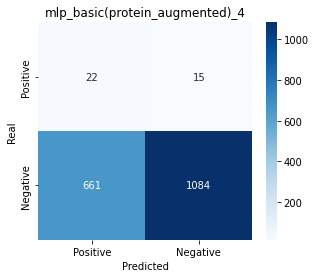

accuracy  : 62.07
precision : [98.64  3.22]
recall    : [62.12 59.46]
f1_score  : [76.23  6.11]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.044280442804428034 1.0317869415807561
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_5of10.h5


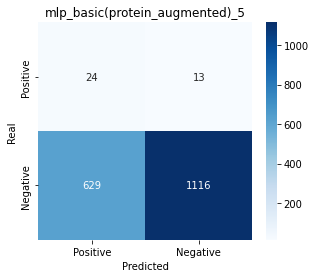

accuracy  : 63.970000000000006
precision : [98.85  3.68]
recall    : [63.95 64.86]
f1_score  : [77.66  6.96]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.0008045052292839445 1.001002004008016
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_6of10.h5


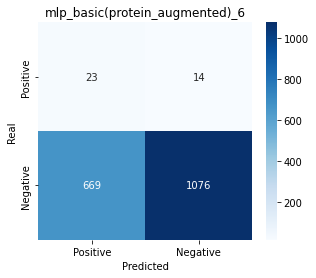

accuracy  : 61.67
precision : [98.72  3.32]
recall    : [61.66 62.16]
f1_score  : [75.91  6.31]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.024289831206257745 1.0
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_7of10.h5


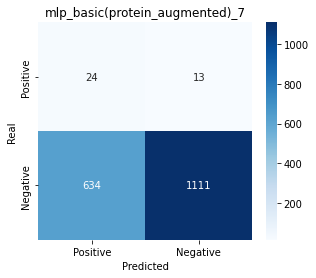

accuracy  : 63.690000000000005
precision : [98.84  3.65]
recall    : [63.67 64.86]
f1_score  : [77.45  6.91]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: 0.0 1.0136986301369864
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_8of10.h5


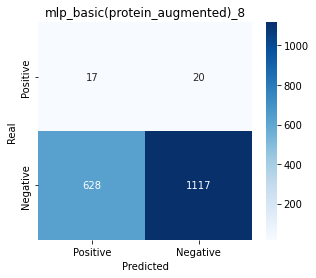

accuracy  : 63.63999999999999
precision : [98.24  2.64]
recall    : [64.01 45.95]
f1_score  : [77.52  4.99]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_9of10.h5


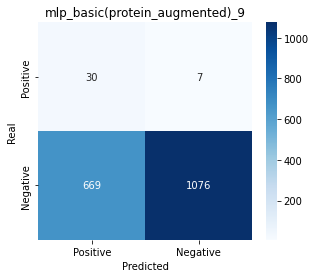

accuracy  : 62.07
precision : [99.35  4.29]
recall    : [61.66 81.08]
f1_score  : [76.1   8.15]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 16) (7128, 1)
check scale: 0.0 1.0

test: (1782, 16) (1782, 1)
check scale: -0.01318807339449548 1.027777777777778
up-sampled train dataset: (13960, 16) (13960, 1)
MLP model has been restored from ./h5/mlp_basic(protein_augmented)_5_100_cv_10of10.h5


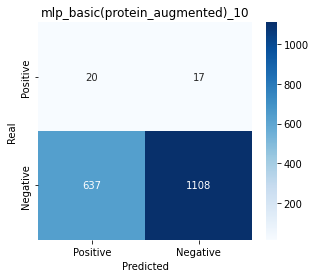

accuracy  : 63.3
precision : [98.49  3.04]
recall    : [63.5  54.05]
f1_score  : [77.21  5.76]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])